In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,10]

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from functools import reduce
from pyspark.sql import DataFrame

import pandas as pd
import numpy as np

# Set up SparkContext
conf = SparkConf().setMaster('local')
#sc = SparkContext(conf = conf)

spark = SparkSession.builder.master("local[8]").appName("explore_malware").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
sc = spark.sparkContext

In [3]:
PATH = "DATA/"
file = "Kaggle-data.csv"

# Explore and sanatize the dataset 


    1 - There is one line that is misaligned creating the column c57 at the end of the dataframe

    2 - There are some repetitive Md5 signature and some of them needs to be purged either because of redundancy and because of incoherence between redundancy

    3 - The variable _VersionInformationSize_ should not be included in the training set. Is a source of incoherence in the redundancy of MD5 signatures 

In [4]:
dd_malware = spark.read.format("csv").load(PATH + file,header='true', inferSchema='true')

In [5]:
dd_malware.show(20,False)

+---+--------------------------------+-------+--------------------+---------------+------------------+------------------+----------+---------------------+-----------------------+-------------------+----------+----------+------------+----------------+-------------+---------------------------+---------------------------+-----------------+-----------------+---------------------+---------------------+-----------+-------------+--------+---------+------------------+------------------+-----------------+-----------------+----------------+-----------+-------------------+----------+-------------------+------------------+------------------+-------------------+------------------+-----------------+-----------------------+----------------------+---------------------+------------+---------+----------------+--------+-----------+--------------------+-------------------+-------------------+-----------------+----------------+----------------+---------------------+----------------------+----------+----+
|

In [6]:
dd_malware.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- md5: string (nullable = true)
 |-- Machine: string (nullable = true)
 |-- SizeOfOptionalHeader: integer (nullable = true)
 |-- Characteristics: integer (nullable = true)
 |-- MajorLinkerVersion: integer (nullable = true)
 |-- MinorLinkerVersion: integer (nullable = true)
 |-- SizeOfCode: long (nullable = true)
 |-- SizeOfInitializedData: long (nullable = true)
 |-- SizeOfUninitializedData: long (nullable = true)
 |-- AddressOfEntryPoint: long (nullable = true)
 |-- BaseOfCode: long (nullable = true)
 |-- BaseOfData: integer (nullable = true)
 |-- ImageBase: double (nullable = true)
 |-- SectionAlignment: integer (nullable = true)
 |-- FileAlignment: integer (nullable = true)
 |-- MajorOperatingSystemVersion: integer (nullable = true)
 |-- MinorOperatingSystemVersion: integer (nullable = true)
 |-- MajorImageVersion: integer (nullable = true)
 |-- MinorImageVersion: integer (nullable = true)
 |-- MajorSubsystemVersion: integer (nullable = tru

In [7]:
dd_malware.createOrReplaceTempView('malware')

In [8]:
dd_quality = spark.sql("""

    select id
    from malware
    where _c57 is not null

""")

In [9]:
dd_quality.count()

1

In [10]:
dd_malware1 = dd_malware.filter(F.col("_c57").isNull()).drop(F.col("_c57"))
dd_malware1.createOrReplaceTempView('malware1')

var_size_file = dd_malware.count()
var_size_dataFrame_orig = dd_malware1.count()

print("orig size : ", var_size_file)
print("size without null : ", var_size_dataFrame_orig)

orig size :  216352
size without null :  216351


## Analysis of each columns 

### Class balance 

In [11]:
df_class_balance = dd_malware1.select('legitimate').groupby('legitimate').count().toPandas()
df_class_balance['prop'] = df_class_balance['count'] / var_size_dataFrame_orig * 100

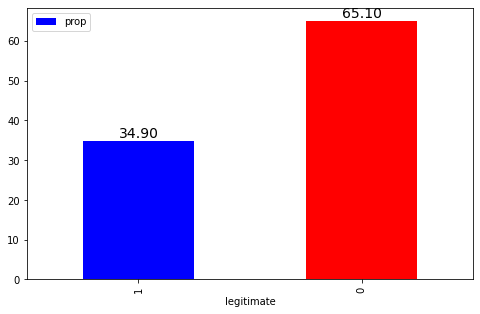

In [13]:
plt.rcParams['figure.figsize'] = [8,5]
ax = df_class_balance.plot.bar(x='legitimate',y='prop',color=['b','r'])

for container in ax.containers:
    ax.bar_label(container,fmt="%.2f",size=14)


If the interpretation of the value 1 means that the software is legitimate and 0 is malicious, then the data is dominated by by malicious software signatures. 

Nonetheless, we are not in the realm of super imbalanced classes here like we usually see in credit card fraud detection. 

### The rest

In [14]:
%%time
df_malware1_summary = dd_malware1.summary().toPandas()
df_malware1_summary.set_index('summary',drop=True,inplace=True)
df_malware1_summary.T

Wall time: 25.7 s


summary,count,mean,stddev,min,25%,50%,75%,max
ID,216351,108176.80604203355,62455.5691692465,1,54081,108181,162257,216352
md5,216351,Infinity,None,00002452c54bb3ea8c6633b69b0d70e0,Infinity,Infinity,Infinity,ffff110cd8484dd75795eb2c94f2ca41
Machine,216351,3280.523464185513,9579.778943568079,332,332.0,332.0,332.0,512
SizeOfOptionalHeader,216351,225.3897046928371,4.554230061683273,176,224,224,224,352
Characteristics,216351,4658.039343474262,7843.8675762535695,0,258,271,8450,49551
MajorLinkerVersion,216350,8.899431476773746,5.825689927603854,0,7,9,10,255
MinorLinkerVersion,216351,4.297974125379591,11.965311062951228,0,0,0,0,255
SizeOfCode,216351,395387.5391701448,1.9627799242878698E7,0,25600,101888,122880,4294967295
SizeOfInitializedData,216351,582798.9215395353,2.8411126682290025E7,0,15360,119808,385024,4294967295
SizeOfUninitializedData,216351,1332429.452953765,7.337825965878619E7,0,0,0,0,4294967295


In [15]:
for col in dd_malware1.columns:
    print(col, "\t", "with null values: ", dd_malware1.filter(dd_malware1[col].isNull()).count())

ID 	 with null values:  0
md5 	 with null values:  0
Machine 	 with null values:  0
SizeOfOptionalHeader 	 with null values:  0
Characteristics 	 with null values:  0
MajorLinkerVersion 	 with null values:  1
MinorLinkerVersion 	 with null values:  0
SizeOfCode 	 with null values:  0
SizeOfInitializedData 	 with null values:  0
SizeOfUninitializedData 	 with null values:  0
AddressOfEntryPoint 	 with null values:  0
BaseOfCode 	 with null values:  0
BaseOfData 	 with null values:  0
ImageBase 	 with null values:  0
SectionAlignment 	 with null values:  0
FileAlignment 	 with null values:  0
MajorOperatingSystemVersion 	 with null values:  0
MinorOperatingSystemVersion 	 with null values:  0
MajorImageVersion 	 with null values:  0
MinorImageVersion 	 with null values:  0
MajorSubsystemVersion 	 with null values:  0
MinorSubsystemVersion 	 with null values:  0
SizeOfImage 	 with null values:  0
SizeOfHeaders 	 with null values:  0
CheckSum 	 with null values:  0
Subsystem 	 with null va

In [16]:
dd_malware1.filter(F.col('MajorLinkerVersion').isNull()).show()

+---+--------------------+-------+--------------------+---------------+------------------+------------------+----------+---------------------+-----------------------+-------------------+----------+----------+------------+----------------+-------------+---------------------------+---------------------------+-----------------+-----------------+---------------------+---------------------+-----------+-------------+--------+---------+------------------+------------------+-----------------+-----------------+----------------+-----------+-------------------+----------+-------------------+------------------+------------------+-------------------+------------------+-----------------+-----------------------+----------------------+---------------------+------------+---------+----------------+--------+-----------+--------------------+-------------------+-------------------+-----------------+----------------+----------------+---------------------+----------------------+----------+
| ID|             

### According to the quartiles above, many columns seem to be dominated by a single modal value, let's test it

In [17]:
def get_modes(df):
    return [[i]+list(df.groupby(i).count().orderBy("count", ascending=False).first()) for i in df.columns[:-1]]
modes = get_modes(dd_malware1)

In [18]:
df_modes = pd.DataFrame(modes,columns=['column','value','freq'])
df_modes['prop'] = df_modes.freq/var_size_dataFrame_orig
df_modes.sort_values('freq',ascending=False).head(10)

,column,value,freq,prop
31,LoaderFlags,0,216255,0.999556
32,NumberOfRvaAndSizes,16,216158,0.999108
30,SizeOfHeapCommit,4096,212327,0.981401
29,SizeOfHeapReserve,1048576,209601,0.968801
14,SectionAlignment,4096,201475,0.931241
2,Machine,332,197618,0.913414
3,SizeOfOptionalHeader,224,197609,0.913372
15,FileAlignment,512,194747,0.900144
28,SizeOfStackCommit,4096,191246,0.883962
11,BaseOfCode,4096,190647,0.881193


In [19]:
df_modes.sort_values('freq',ascending=False).tail(10)

,column,value,freq,prop
41,SectionsMinVirtualsize,12.0,15198,0.070247
51,ResourcesMeanSize,2739.5,11588,0.053561
10,AddressOfEntryPoint,0,11456,0.052951
48,ResourcesMeanEntropy,0.0,9836,0.045463
42,SectionMaxVirtualsize,339652,9121,0.042158
40,SectionsMeanVirtualsize,102635.8,6028,0.027862
36,SectionsMaxEntropy,7.963098,6021,0.027830
34,SectionsMeanEntropy,5.659356,6021,0.027830
1,md5,9873531e6ba01adecf7e1e0f68c2df1a,25,0.000116
0,ID,148,1,0.000005


In [20]:
len(df_modes.query("prop < 0.7"))

38

### Interesting, there seems to be repetitive MD5, collisions ?? 

'md5', ('9873531e6ba01adecf7e1e0f68c2df1a', 25)

In [21]:
# There seems to be repetitive md5, here is an example : 

dd_malware1.filter("md5 == '9873531e6ba01adecf7e1e0f68c2df1a'").show(25,False)

+-----+--------------------------------+-------+--------------------+---------------+------------------+------------------+----------+---------------------+-----------------------+-------------------+----------+----------+------------+----------------+-------------+---------------------------+---------------------------+-----------------+-----------------+---------------------+---------------------+-----------+-------------+--------+---------+------------------+------------------+-----------------+-----------------+----------------+-----------+-------------------+----------+-------------------+------------------+------------------+-------------------+------------------+-----------------+-----------------------+----------------------+---------------------+------------+---------+----------------+--------+-----------+--------------------+-------------------+-------------------+-----------------+----------------+----------------+---------------------+----------------------+----------+
|ID 

In [22]:
dd_repet_md5 = spark.sql("""

    select md5, count(distinct id) as freq
    from malware1
    group by md5
    having count(distinct id) > 1

""")

In [23]:
var_repet_md5_count = dd_repet_md5.count()
var_repet_md5_sum   = dd_repet_md5.select(F.sum('freq')).collect()[0][0]

print("Number of multiple MD5 : ", var_repet_md5_count)
print("Number of lines for multiple MD5 : ", var_repet_md5_sum)
print("Ratio of : ",var_repet_md5_sum/var_repet_md5_count)

Number of multiple MD5 :  6022
Number of lines for multiple MD5 :  13045
Ratio of :  2.1662238458983727


In [24]:
dd_repet_distinct_md5 = spark.sql("""

    with temp1 as (

        select md5, count(distinct id)
        from malware1
        group by md5
        having count(distinct id) > 1
    )
    select distinct b.*
    from temp1 as a inner join (select """ + ",".join(dd_malware1.columns[1:]) + """ from malware1) as b
    on a.md5 = b.md5

""")

In [25]:
var_reped_distinct_md5_count = dd_repet_distinct_md5.count()
print("Number of multiple DISTINCT MD5 : ", var_reped_distinct_md5_count)

Number of multiple DISTINCT MD5 :  10872


In [26]:
dd_repet_distinct_md5.createOrReplaceTempView('repet_distinct_md5')

# Dirty rows are defined as being Redundant MD5s after controling for simple duplicates (distinct) for each columns
def get_dirty_row(col):
    dd = spark.sql("""

        with temp1 as (
            select md5, count(*) as freq
            from repet_distinct_md5
            group by md5
            having count(*) > 1
        ), temp2 as (
            select a.md5, count(distinct b.""" + col + """) as nb_dist
            from temp1 as a inner join repet_distinct_md5 as b
            on a.md5 = b.md5
            group by a.md5
        )
        select count(*) as freq_md5, sum(case when nb_dist > 1 then 1 else 0 end) as freq_multiple
        from temp2

    """)
    return dd

In [27]:
col_consistency = []
for col in dd_repet_distinct_md5.columns[1:]:
    #print(col)
    row = get_dirty_row(col).first()
    col_consistency.append([col,row.freq_md5, row.freq_multiple, row.freq_multiple/row.freq_md5])


In [28]:
df_consistency = pd.DataFrame(col_consistency,columns=['col_name','freq_md5','freq_multiple', 'prop_multiple'])
df_consistency.sort_values('prop_multiple',ascending=False).head(10)

,col_name,freq_md5,freq_multiple,prop_multiple
53,VersionInformationSize,4805,4795,0.997919
43,ImportsNbOrdinal,4805,1336,0.278044
54,legitimate,4805,61,0.012695
44,ExportNb,4805,27,0.005619
52,LoadConfigurationSize,4805,1,0.000208
39,SectionsMinVirtualsize,4805,0,0.000000
30,NumberOfRvaAndSizes,4805,0,0.000000
31,SectionsNb,4805,0,0.000000
32,SectionsMeanEntropy,4805,0,0.000000
33,SectionsMinEntropy,4805,0,0.000000


Seems like the column VersionInformationSize is generating the vast majority of those "duplicates". We can't trust that column, will be dropped. But the distinct values kept.

Other duplicates originating from the other columns will be removed. We can't trust those rows

In [29]:
dd_malware1_wo_Version = dd_malware1.drop('VersionInformationSize')
dd_malware1_wo_Version.createOrReplaceTempView('malware1_wo_Version')

dd_repet_distinct_md5_wo_Version = spark.sql("""

    with temp1 as (

        select md5, count(distinct id)
        from malware1_wo_Version
        group by md5
        having count(distinct id) > 1
    )
    select distinct b.*
    from temp1 as a inner join (select """ + ",".join(dd_malware1_wo_Version.columns[1:]) + """ from malware1_wo_Version) as b
    on a.md5 = b.md5

""")

In [30]:
var_reped_distinct_md5__wo_version_count = dd_repet_distinct_md5_wo_Version.count()
print("Number of multiple DISTINCT MD5 : ", var_reped_distinct_md5__wo_version_count)

Number of multiple DISTINCT MD5 :  7440


In [31]:
# Let's select the list of undesired MD5s 

dd_md5_to_remove = spark.sql("""

    with temp1 as (

        select md5, count(distinct id)
        from malware1_wo_Version
        group by md5
        having count(distinct id) > 1
    ), temp2 as (
        select distinct b.*
        from temp1 as a inner join (select """ + ",".join(dd_malware1_wo_Version.columns[1:]) + """ from malware1_wo_Version) as b
        on a.md5 = b.md5
    )
    select md5, count(*) as freq
    from temp2
    group by md5
    having count(*) > 1

""")

In [32]:
dd_md5_to_remove.count()

1397

In [33]:
dd_md5_to_remove.createOrReplaceTempView('md5_to_remove')

## Let's produce a cleaner DataFrame

In [34]:
dd_malware_clean_0 = spark.sql("""

    with temp1 as (
        select rank() over(partition by m.md5 order by m.id) as rang, m.*
        from malware1_wo_Version as m
        where md5 not in (select md5 from md5_to_remove)
    )
    select """ + ",".join(dd_malware1_wo_Version.columns) + """
    from temp1
    where rang = 1

""")

In [35]:
%%time
var_size_dataFrame_clean_0 = dd_malware_clean_0.count()

Wall time: 7.64 s


In [36]:
print("Number of rows removed : ",var_size_dataFrame_orig - var_size_dataFrame_clean_0)
print("Proportion of rows removed :", (var_size_dataFrame_orig - var_size_dataFrame_clean_0)/var_size_dataFrame_orig*100)

Number of rows removed :  8420
Proportion of rows removed : 3.8918239342549836


In [37]:
dd_malware_clean_0.cache()
dd_malware_clean_0.createOrReplaceTempView('malware_clean')

### Let see if some columns needs to be removed because they are too dominated by their modal value

In [38]:
df_modes.sort_values('freq',ascending=False).head(60)

,column,value,freq,prop
31,LoaderFlags,0,216255,0.999556
32,NumberOfRvaAndSizes,16,216158,0.999108
30,SizeOfHeapCommit,4096,212327,0.981401
29,SizeOfHeapReserve,1048576,209601,0.968801
14,SectionAlignment,4096,201475,0.931241
2,Machine,332,197618,0.913414
3,SizeOfOptionalHeader,224,197609,0.913372
15,FileAlignment,512,194747,0.900144
28,SizeOfStackCommit,4096,191246,0.883962
11,BaseOfCode,4096,190647,0.881193


In [39]:
from re import search

def get_perfo_out_modes(col,value):

    if search('[a-zA-Z]',str(value)):
        value = "'" + value + "'"
    
    return [col] + list( spark.sql("""

        select count(*) as freq, sum(Legitimate) as nb_frd, sum(Legitimate)/count(*) as prop_legit, (count(*) - sum(Legitimate))/count(*) as prop_malicious
        from malware_clean
        where """ + col + """ <> """ + str(value) + """

    """).first())

In [40]:
# ATTENTION !!! df_modes was obtained from DD_MALWARE1, which do not have the exact same colums as DD_MALWARE_CLEAN_0
perfo_out_modes = [get_perfo_out_modes(i,j) for i,j in df_modes.query("column != 'VersionInformationSize'")[['column','value']].values.tolist()]

In [41]:
df_perfo_out_modes = pd.DataFrame(perfo_out_modes,columns=['column','count_out_mode','nb_frd_out_mode','prop_legit','prop_malicious'])

df_modes_out_modes = pd.merge(df_modes,df_perfo_out_modes,on='column',how='left')

### Let's define the variables to keep because values outsite the mode are relevant to the flag

In [42]:
df_modes_out_modes.query("column != 'legitimate' and (prop_legit >= 0.90 or prop_malicious >= 0.9)")

,column,value,freq,prop,count_out_mode,nb_frd_out_mode,prop_legit,prop_malicious
2,Machine,332,197618,0.913414,18447.0,17590.0,0.953543,0.046457
3,SizeOfOptionalHeader,224,197609,0.913372,18457.0,17587.0,0.952863,0.047137
9,SizeOfUninitializedData,0,189582,0.876271,26657.0,1341.0,0.050306,0.949694
31,LoaderFlags,0,216255,0.999556,96.0,3.0,0.031250,0.968750
32,NumberOfRvaAndSizes,16,216158,0.999108,193.0,1.0,0.005181,0.994819


### Let's define the variables to drop because the values outside the mode are irrelevant to the flag

In [43]:
df_modes_out_modes.query("column != 'legitimate' and prop >= 0.7 and (prop_legit < 0.90 and prop_malicious < 0.9)")

,column,value,freq,prop,count_out_mode,nb_frd_out_mode,prop_legit,prop_malicious
6,MinorLinkerVersion,0,175180,0.809703,40660.0,15318.0,0.376734,0.623266
11,BaseOfCode,4096,190647,0.881193,24786.0,11504.0,0.464133,0.535867
14,SectionAlignment,4096,201475,0.931241,13975.0,8431.0,0.603292,0.396708
15,FileAlignment,512,194747,0.900144,20770.0,7089.0,0.341310,0.658690
19,MinorImageVersion,0,174234,0.805330,37353.0,32456.0,0.868899,0.131101
23,SizeOfHeaders,1024,168417,0.778443,45650.0,19424.0,0.425498,0.574502
25,Subsystem,2,166566,0.769888,44888.0,39358.0,0.876804,0.123196
27,SizeOfStackReserve,1048576,154348,0.713415,56699.0,46089.0,0.812871,0.187129
28,SizeOfStackCommit,4096,191246,0.883962,23964.0,9757.0,0.407152,0.592848
29,SizeOfHeapReserve,1048576,209601,0.968801,6551.0,4415.0,0.673943,0.326057


In [44]:
variables_modes_binary = df_modes_out_modes.query("column != 'legitimate' and (prop_legit >= 0.90 or prop_malicious >= 0.9)")['column'].values.tolist()
variables_modes_drop = df_modes_out_modes.query("column != 'legitimate' and prop >= 0.7 and (prop_legit < 0.90 and prop_malicious < 0.9)")['column'].values.tolist()

variables_control = ['ID','md5','legitimate']

print("Vars Control : ",variables_control)
print("Vars to one hot encode according to mode : ", variables_modes_binary)
print("Vars to drop from the DataFramde : ",variables_modes_drop)

Vars Control :  ['ID', 'md5', 'legitimate']
Vars to one hot encode according to mode :  ['Machine', 'SizeOfOptionalHeader', 'SizeOfUninitializedData', 'LoaderFlags', 'NumberOfRvaAndSizes']
Vars to drop from the DataFramde :  ['MinorLinkerVersion', 'BaseOfCode', 'SectionAlignment', 'FileAlignment', 'MinorImageVersion', 'SizeOfHeaders', 'Subsystem', 'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve', 'SizeOfHeapCommit', 'ImportsNbOrdinal', 'ExportNb']


### Drop columns and work on transforming the columns

    - We have the columns that are dominated with usefull modes (_variables_modes_binary_) 
    - We have variables that span on many order magnitudes (unknown)
    - We have more reasonable variable domains (unknown)

In [45]:
dd_malware_clean_1 = dd_malware_clean_0.drop(*tuple(variables_modes_drop))
dd_malware_clean_1.cache()
dd_malware_clean_0.unpersist()
dd_malware_clean_1.createOrReplaceTempView('malware_clean1')

In [46]:
to_explore = [i for i in dd_malware_clean_1.dtypes if ((i[1] != 'string') & ( i[0] not in variables_control) & ( i[0] not in variables_modes_binary))]

In [47]:
def get_col_span(dd,col):
    
    row = (dd.select(F.lit(col).alias('column_name'), F.ceil(F.log10(F.col(col) + 1)).alias('log_col'),col,'ID')
                                .groupby('log_col','column_name')
                                .count()
                                .agg(
                                    F.max('column_name').alias('col'),
                                    F.min('log_col').alias('min_log'),
                                    F.max('log_col').alias('max_log'), 
                                    F.count('log_col').alias('freq'))
                                 .first())
    col_name = row.col
    nb_orders = row.freq
    min_orders = row.min_log
    max_orders = row.max_log
    span_orders = max_orders - min_orders

    return [col_name, nb_orders, min_orders, max_orders ,span_orders]


In [48]:
%%time
columns_span = [get_col_span(dd_malware_clean_1, i[0]) for i in to_explore]

Wall time: 2min 15s


In [49]:
df_columns_span = pd.DataFrame(columns_span,columns=['column','nb_orders','min_order','max_order','span_order'])

In [50]:
df_columns_span.sort_values('nb_orders',ascending=False)

,column,nb_orders,min_order,max_order,span_order
6,ImageBase,11,5,20,15
33,ResourcesMaxSize,11,0,10,10
31,ResourcesMeanSize,11,0,10,10
13,CheckSum,11,0,10,10
34,LoadConfigurationSize,10,0,10,10
2,SizeOfCode,10,0,10,10
21,SectionMaxRawsize,10,0,10,10
22,SectionsMeanVirtualsize,10,0,10,10
5,BaseOfData,10,0,10,10
19,SectionsMeanRawsize,10,0,10,10


### If the number of orders of magnitude is greater than 5 then we do a LOG10 transformation, otherwise we will scale

In [51]:
variables_to_log_transform = df_columns_span.query("nb_orders >= 5")['column'].values.tolist()
variables_to_scale = df_columns_span.query("nb_orders < 5")['column'].values.tolist()
print("Variables to log transform :", variables_to_log_transform)
print("Variables to scale         :", variables_to_scale)

Variables to log transform : ['Characteristics', 'SizeOfCode', 'SizeOfInitializedData', 'AddressOfEntryPoint', 'BaseOfData', 'ImageBase', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorSubsystemVersion', 'SizeOfImage', 'CheckSum', 'DllCharacteristics', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize', 'SectionsMeanVirtualsize', 'SectionsMinVirtualsize', 'SectionMaxVirtualsize', 'ImportsNb', 'ResourcesNb', 'ResourcesMeanSize', 'ResourcesMinSize', 'ResourcesMaxSize', 'LoadConfigurationSize']
Variables to scale         : ['MajorLinkerVersion', 'MajorSubsystemVersion', 'SectionsNb', 'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy', 'ImportsNbDLL', 'ResourcesMeanEntropy', 'ResourcesMinEntropy', 'ResourcesMaxEntropy']


## Save results to build the pipeline : 

In [82]:
# Save the cleaned datafile : 
nb_partition = dd_malware_clean_1.rdd.getNumPartitions()
print("Number of partition to the file : ", nb_partition)
if nb_partition > 8:
    dd_malware_clean_1 = dd_malware_clean_1.repartition(8)
nb_partition = dd_malware_clean_1.rdd.getNumPartitions()
print("Number of partition to the file END : ", nb_partition)

Number of partition to the file :  200
Number of partition to the file END :  8


In [84]:
%%time
dd_malware_clean_1.write.mode('overwrite').parquet(PATH + "malware_clean")

Wall time: 7.9 s


In [85]:
import pickle

def write_var_files(name,liste):
    with open(PATH + name, 'wb') as fp:
        pickle.dump(liste, fp)

In [88]:
write_var_files("variables_to_log_transform",variables_to_log_transform)
write_var_files("variables_to_modes_binary",variables_modes_binary)
write_var_files("variables_to_scale",variables_to_scale)
write_var_files("variables_control",variables_control)

# Residue

In [87]:
with open (PATH + "to_log_transform", 'rb') as fp:
    test = pickle.load(fp)
    
print(test)

['Characteristics', 'SizeOfCode', 'SizeOfInitializedData', 'AddressOfEntryPoint', 'BaseOfData', 'ImageBase', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorSubsystemVersion', 'SizeOfImage', 'CheckSum', 'DllCharacteristics', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize', 'SectionsMeanVirtualsize', 'SectionsMinVirtualsize', 'SectionMaxVirtualsize', 'ImportsNb', 'ResourcesNb', 'ResourcesMeanSize', 'ResourcesMinSize', 'ResourcesMaxSize', 'LoadConfigurationSize']


In [ ]:
def get_col_span(dd,col):
    
    row = (dd.select(F.lit(col).alias('column_name'), F.ceil(F.log10(F.col(col) + 1)).alias('log_col'),col,'ID')
                                .groupby('log_col','column_name')
                                .count()
                                .agg(
                                    F.max('column_name').alias('col'),
                                    F.min('log_col').alias('min_log'),
                                    F.max('log_col').alias('max_log'), 
                                    F.count('log_col').alias('freq'))
                                 )
    return row

In [ ]:
%%time
#dd_columns_span = get_col_span(dd_malware_clean_1, to_explore[0][0])
#dd_columns_span = dd_columns_span.union(get_col_span(dd_malware_clean_1, i[0])) for i in to_explore[1:]
columns_span = [get_col_span(dd_malware_clean_1, i[0]) for i in to_explore]

dd_columns_span = reduce(DataFrame.unionAll, columns_span)

In [ ]:
%%time
dd_columns_span.show(60)

In [ ]:
dd_malware1.show()